Ce mini-projet conciste à comparer deux modeles differents afin d'y effectuer une analyse sentimentale des differents avis sur des produits d'Amazon. En bonus on créé un pipeline où l'on pourra injecter des phrases afin de vérifier leurs poolaritées.

In [8]:
#On importe les librairies
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk 
#lire les données 

df= pd.read_csv('Reviews.csv')

In [9]:
df.head()
df=df.head(500)

(500, 10)


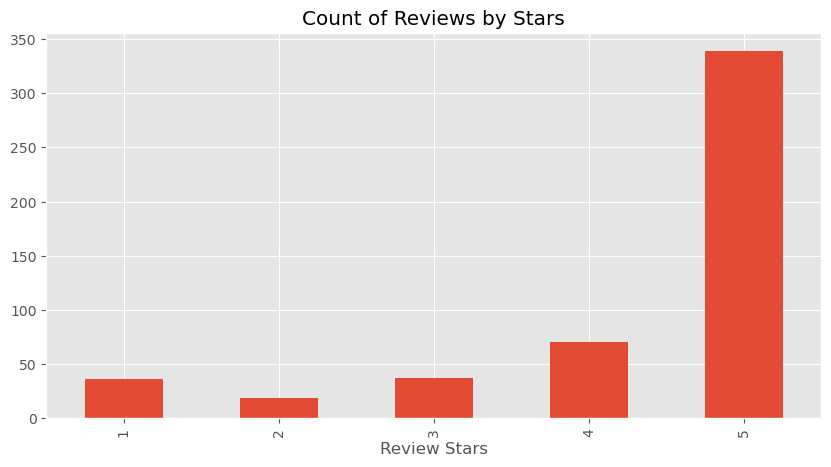

In [10]:
# Data Preprocessing
print(df.shape)

ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

On remarque que la note de 5 est plus representée. 

## NLTK

In [26]:
exempl = df['Text'][80]
print(exempl)

This peppermint stick is delicious and fun to eat.  My dad got me one for Christmas because he remembered me having a similar one when I was a little girl.  I'm 30 now and I love it!


In [12]:
nltk.download('punkt')
tokens = nltk.word_tokenize(exempl)
tokens[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['This',
 'peppermint',
 'stick',
 'is',
 'delicious',
 'and',
 'fun',
 'to',
 'eat',
 '.']

In [13]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('peppermint', 'NN'),
 ('stick', 'NN'),
 ('is', 'VBZ'),
 ('delicious', 'JJ'),
 ('and', 'CC'),
 ('fun', 'NN'),
 ('to', 'TO'),
 ('eat', 'VB'),
 ('.', '.')]

In [14]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  peppermint/NN
  stick/NN
  is/VBZ
  delicious/JJ
  and/CC
  fun/NN
  to/TO
  eat/VB
  ./.
  My/PRP$
  dad/NN
  got/VBD
  me/PRP
  one/CD
  for/IN
  (PERSON Christmas/NNP)
  because/IN
  he/PRP
  remembered/VBD
  me/PRP
  having/VBG
  a/DT
  similar/JJ
  one/CD
  when/WRB
  I/PRP
  was/VBD
  a/DT
  little/JJ
  girl/NN
  ./.
  I/PRP
  'm/VBP
  30/CD
  now/RB
  and/CC
  I/PRP
  love/VBP
  it/PRP
  !/.)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package words is already up-to-date!


# VADER Sentiment Scoring

On va utiliser NLTK 'SenttimentIntensityAnalyser' pour obtenir les scores : Neg/Neu/Pos du text.
Grace à une approche des sacs de mots: 
- On supprime les stop words 
- chaque mots est noté et combiné au score total


In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [17]:
sia.polarity_scores('I am so sad!')

{'neg': 0.648, 'neu': 0.352, 'pos': 0.0, 'compound': -0.5697}

In [18]:
sia.polarity_scores(exempl)

{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.9098}

On va faire tourner le score de polarite sur tout le dataset 

In [19]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

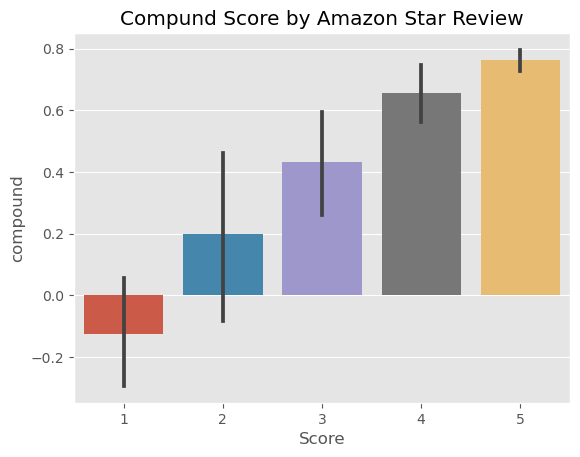

In [21]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

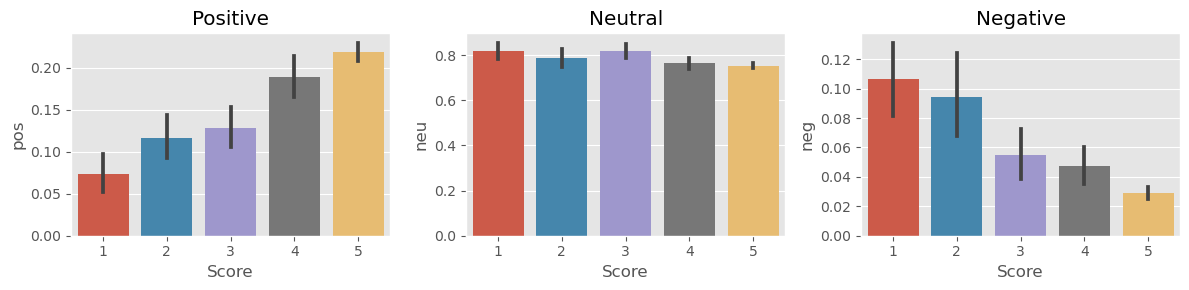

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Etape 3 Roberta 

- On utilise un modele entrainé sur un grand corpus de texte 
- Le modele prend en compte le mots mais egalement le contexte 

In [23]:
#!pip install transformer
!pip install torch
!pip install scipy
!pip install --upgrade transformers torch scipy

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [24]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [27]:
# VADER results on example
print(exempl)
sia.polarity_scores(exempl)

This peppermint stick is delicious and fun to eat.  My dad got me one for Christmas because he remembered me having a similar one when I was a little girl.  I'm 30 now and I love it!


{'neg': 0.0, 'neu': 0.723, 'pos': 0.277, 'compound': 0.9098}

In [29]:
# Run for Roberta Model
encoded_text = tokenizer(exempl, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0015721087, 'roberta_neu': 0.006269506, 'roberta_pos': 0.9921584}


In [30]:
def polarity_scores_roberta(exempl):
    encoded_text = tokenizer(exempl, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [31]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [33]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

# On compare les scores entres les deux modeles

In [34]:
results_df.columns


Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# On combine les deux 

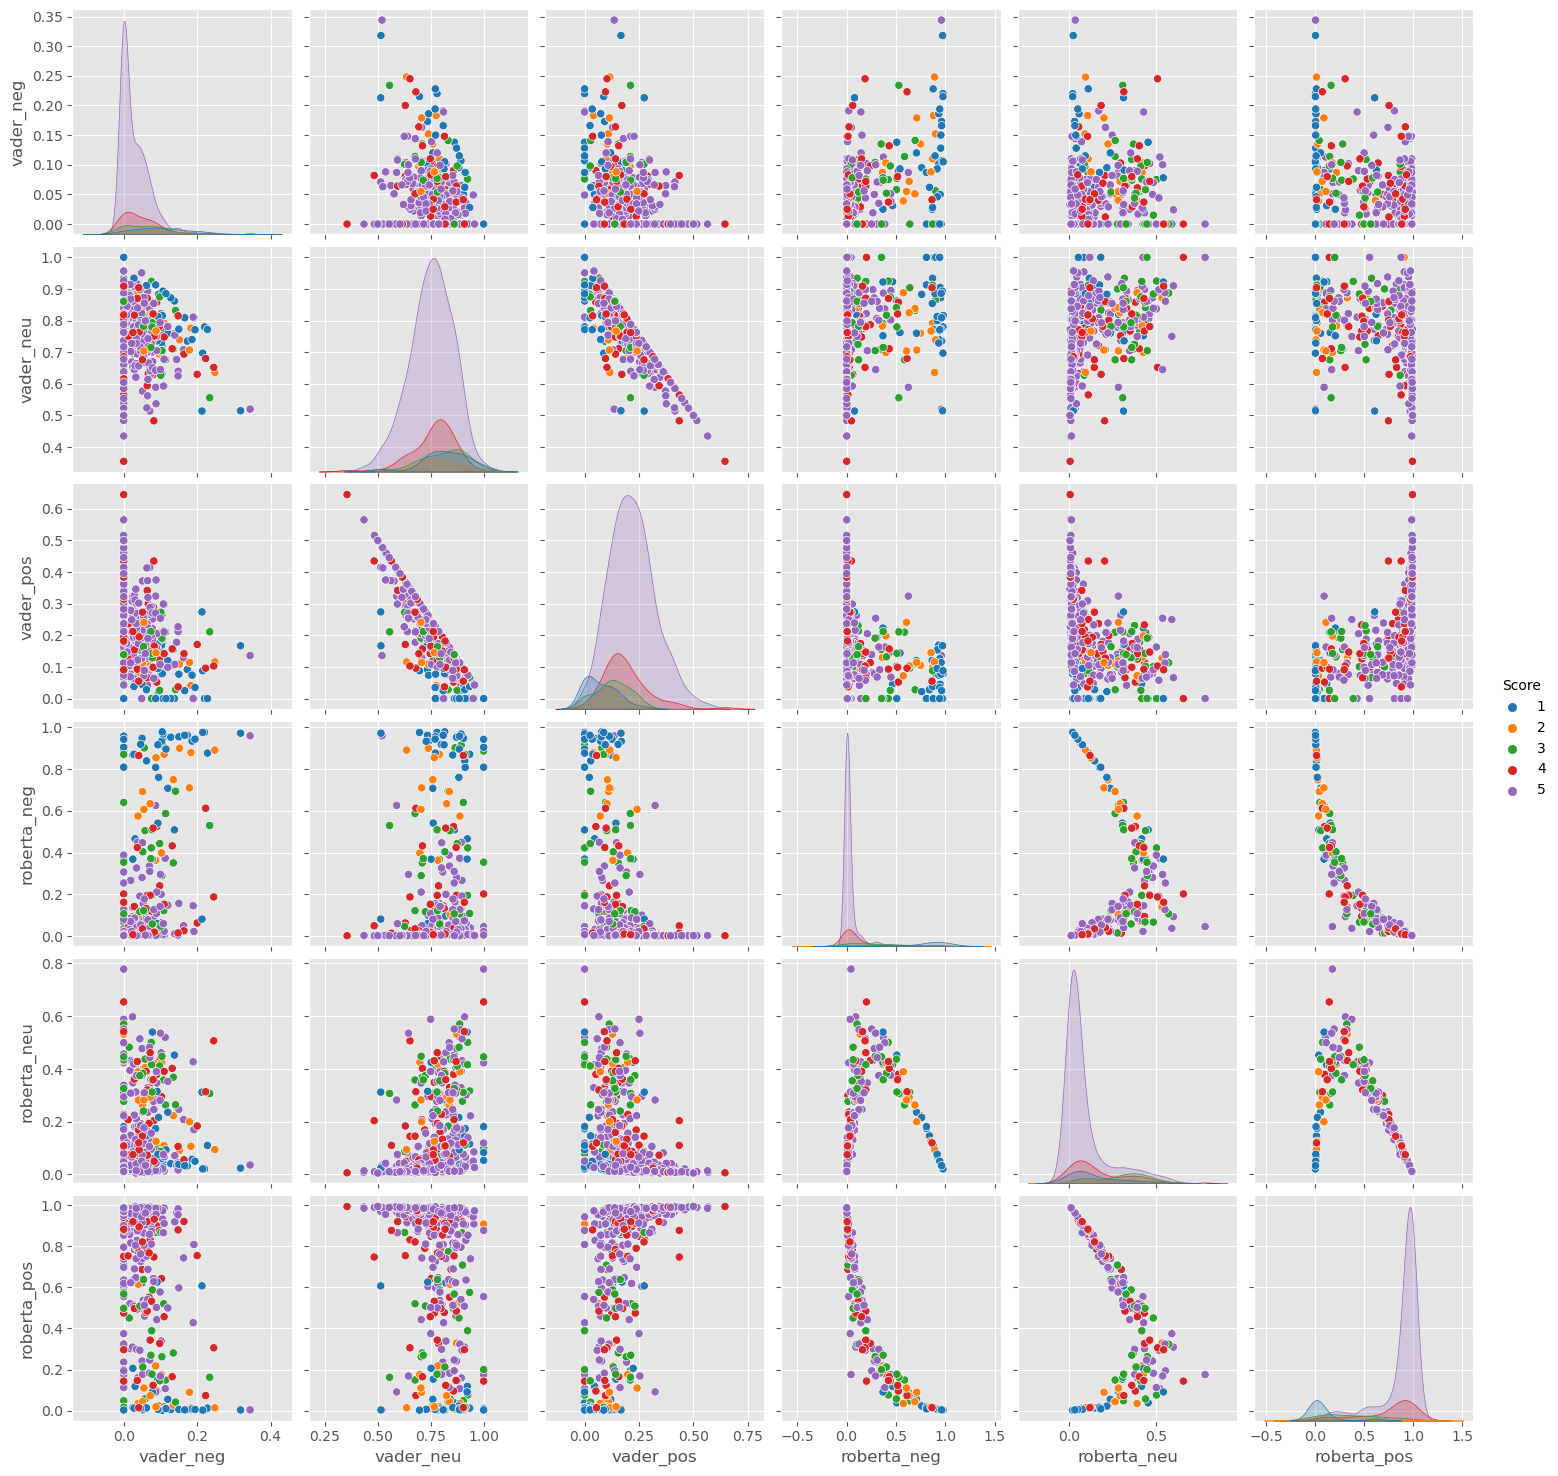

In [35]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

On compare quelque exemple oû les scores different le plus 

In [36]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [37]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

Les sentiment negatifs notee 5 etoiles 

In [38]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [39]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Transformers Pipeline 

On va faire quelque predictions 

In [40]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [41]:
sent_pipeline('I love sentiment natural Language Processing!')


[{'label': 'POSITIVE', 'score': 0.9998286962509155}]

In [42]:
sent_pipeline('I hate school so much!')


[{'label': 'NEGATIVE', 'score': 0.9989894032478333}]

In [43]:
sent_pipeline('Fuck you')


[{'label': 'NEGATIVE', 'score': 0.9923542737960815}]

In [44]:
sent_pipeline('What the Fuck! It is so good')


[{'label': 'POSITIVE', 'score': 0.9998641014099121}]

In [45]:
sent_pipeline('product different from pics')

[{'label': 'POSITIVE', 'score': 0.9850354194641113}]

In [46]:
sent_pipeline('The product do not correspond to the picture')

[{'label': 'NEGATIVE', 'score': 0.9996956586837769}]